* [Environment Setup and Data Import](#environment-setup-and-data-import)<br>
* [The Oasis Brains Datasets](#the-oasis-brains-datasets)<br>
* [Identifying Neurodegeneration with a Neural Network](#identifying-neurodegeneration-with-a-neural-network)<br>
* [Predicting Alzheimer's in Cognitively Normal Subjects](#predicting-alzheimers-in-cognitively-normal-subjects)

# Environment Setup and Data Import

In [1]:
import random
import scipy
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from ann_visualizer.visualize import ann_viz;
from sklearn.tree import export_graphviz
import graphviz

from matplotlib.pyplot import imread
import matplotlib
import numpy as np
import os
import imageio
import cv2
from random import seed
seed(42)

from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.metrics import recall_score, precision_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier

import tensorflow
import keras
from keras import optimizers
from keras.models import Sequential, load_model, Model
from keras.callbacks import TensorBoard
from keras.activations import elu
from keras.initializers import he_normal
from keras.preprocessing import image
from keras.layers import Conv2D, Dense, Activation, Flatten, MaxPooling2D, Dropout, Input
from keras.utils import np_utils
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.layers.normalization import BatchNormalization
from keras import backend as K

from numpy.testing import assert_allclose

import nibabel as nib
from nibabel.testing import data_path

from PIL import Image

import nilearn
from nilearn import image, plotting

import ggplot
from ggplot import aes, geom_point, ggtitle

/Users/glynismattheisen/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d
/Users/glynismattheisen/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
/Users/glynismattheisen/anaconda3/lib/python3.6/site-packages/dicom/__init__.py:53: UserWarning: 
This code is using an older version of pydicom, which is no longer 
maintained as of Jan 2017.  You can access the new pydicom features and API 
by installing `pydicom` from PyPI.
See 'Transitioning to pydicom 1.x' section at pydicom.readthedocs.org 
for mo

# Functions

In [2]:
def get_subject(file_name): # parse out subjectids from file names
    return file_name[0:9]

In [3]:
def get_slice(): # read in all oasis1 data across discs
    
    path = '/Users/glynismattheisen/Desktop/Final/Discs'
    disc_list = os.listdir(path) # get list of discs from directory
    MacOS_file = '.DS_Store'
    if MacOS_file in disc_list:
        disc_list.remove(MacOS_file) # remove MacOS file

    brain_list, total_subjects = [], [] # generate list of brain images for input to NN, all subjects used in study
    
    for disc in disc_list:
        path_ind_disc = f'{path}/{disc}'
        subject_list_p_disc = os.listdir(path_ind_disc) # generate list of subjects in each disc
        if MacOS_file in subject_list_p_disc:
            subject_list_p_disc.remove(MacOS_file) # remove MacOS file
            
        for subj_id in subject_list_p_disc:
            total_subjects.append(subj_id) # maintain a list of all subjects included in study for diagnosis labeling later
    
            path_n4 = path_ind_disc + f'/{subj_id}/FSL_SEG/{subj_id}_mpr_n4_anon_111_t88_masked_gfc_fseg_tra_90.gif'
            path_n3 = path_ind_disc + f'/{subj_id}/FSL_SEG/{subj_id}_mpr_n3_anon_111_t88_masked_gfc_fseg_tra_90.gif'
            path_n6 = path_ind_disc + f'/{subj_id}/FSL_SEG/{subj_id}_mpr_n6_anon_111_t88_masked_gfc_fseg_tra_90.gif'
            path_n5 = path_ind_disc + f'/{subj_id}/FSL_SEG/{subj_id}_mpr_n5_anon_111_t88_masked_gfc_fseg_tra_90.gif'
            
            path_list = [path_n4,path_n3, path_n6,path_n5]
            for i in path_list:
                if os.path.exists(i) == True:
                    brain_list.append(plt.imread(i)) # append if file format exists

    return disc_list, brain_list, total_subjects

In [4]:
def get_diagnosis(total_subjects): # builds a dictionary of subjects and diagnoses
    oasis1 = pd.read_csv('/Users/glynismattheisen/Desktop/Final2/oasis_cross-sectional.csv') # read in summary file
    oasis1['CDR'].fillna(0, inplace=True) # null values are healthy diagnoses
    diagnosis_qual={0.:'normal', 0.5:'alz', 1.:'alz', 2.:'alz' } # convert to labels
    oasis1.replace({"CDR": diagnosis_qual}, inplace=True)
    diagnosis_quant={'normal':0,'alz':1} # convert back to numbers
    oasis1.replace({"CDR": diagnosis_quant}, inplace=True)
    
    subjects = []    # get subject names for each MRI ID
    for subj_id in total_subjects:
        subjects.append(get_subject(subj_id))
        
    subjects = pd.DataFrame(subjects, columns = ['Subject']) # convert to dataframe
    oasis1['Subject'] =oasis1['ID'].apply(get_subject)     # extract subject ID from MR ID
    
    diagnosis_dict= {}     # create a dictionary with subject and diagnosis
    for num in range(0,436):
        diagnosis_dict[oasis1['Subject'][num]] = oasis1['CDR'][num]
        
    diag = [] # create a list of diagnoses to append to dataframe of subjects
    for subj in subjects['Subject']:
        diag.append(diagnosis_dict[subj])

    subjects['Diagnosis'] = pd.DataFrame(diag)
    
    return subjects

In [5]:
def balance_set(subjects, total_subjects, disc_list): # make a list of 236 alz patients in order to even out the lists
    alz_subjects = subjects.sort_values(by='Diagnosis', ascending = False).head(97) # all subjects diagnosed as alz
    alz_subjects = alz_subjects.append(alz_subjects)
    head = alz_subjects.head(42)
    alz_subjects = alz_subjects.append(head)    
    
    for subj in alz_subjects['Subject']:
        total_subjects.append(str(subj) + '_MR1') # maintain a list of all subjects included in study for diagnosis labeling later
    for disc in disc_list:
            path = f'/Users/glynismattheisen/Desktop/Final/Discs/{disc}'

            for i in alz_subjects['Subject']:

                path_n4 = path + f'/{i}_MR1/FSL_SEG/{i}_MR1_mpr_n4_anon_111_t88_masked_gfc_fseg_tra_90.gif'
                path_n3 = path + f'/{i}_MR1/FSL_SEG/{i}_MR1_mpr_n3_anon_111_t88_masked_gfc_fseg_tra_90.gif'
                path_n6 = path + f'/{i}_MR1/FSL_SEG/{i}_MR1_mpr_n6_anon_111_t88_masked_gfc_fseg_tra_90.gif'
                path_n5 = path + f'/{i}_MR1/FSL_SEG/{i}_MR1_mpr_n5_anon_111_t88_masked_gfc_fseg_tra_90.gif'

                path_list = [path_n4,path_n3, path_n6,path_n5]
                for i in path_list:
                    if os.path.exists(i) == True:
                        brain_list.append(plt.imread(i)) # append if file format exists

    brain_array = np.asarray(brain_list)
    return brain_array, alz_subjects

In [6]:
disc_list, brain_list, total_subjects = get_slice()

/Users/glynismattheisen/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:2152: ResourceWarning: unclosed file <_io.BufferedReader name='/Users/glynismattheisen/Desktop/Final/Discs/disc12/OAS1_0448_MR1/FSL_SEG/OAS1_0448_MR1_mpr_n4_anon_111_t88_masked_gfc_fseg_tra_90.gif'>
  return matplotlib.image.imread(fname, format)
/Users/glynismattheisen/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:2152: ResourceWarning: unclosed file <_io.BufferedReader name='/Users/glynismattheisen/Desktop/Final/Discs/disc12/OAS1_0449_MR1/FSL_SEG/OAS1_0449_MR1_mpr_n4_anon_111_t88_masked_gfc_fseg_tra_90.gif'>
  return matplotlib.image.imread(fname, format)
/Users/glynismattheisen/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:2152: ResourceWarning: unclosed file <_io.BufferedReader name='/Users/glynismattheisen/Desktop/Final/Discs/disc12/OAS1_0439_MR1/FSL_SEG/OAS1_0439_MR1_mpr_n4_anon_111_t88_masked_gfc_fseg_tra_90.gif'>
  return matplotlib.image.imread(fname, format)
/Users/gly

/Users/glynismattheisen/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:2152: ResourceWarning: unclosed file <_io.BufferedReader name='/Users/glynismattheisen/Desktop/Final/Discs/disc6/OAS1_0230_MR1/FSL_SEG/OAS1_0230_MR1_mpr_n4_anon_111_t88_masked_gfc_fseg_tra_90.gif'>
  return matplotlib.image.imread(fname, format)
/Users/glynismattheisen/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:2152: ResourceWarning: unclosed file <_io.BufferedReader name='/Users/glynismattheisen/Desktop/Final/Discs/disc6/OAS1_0224_MR1/FSL_SEG/OAS1_0224_MR1_mpr_n4_anon_111_t88_masked_gfc_fseg_tra_90.gif'>
  return matplotlib.image.imread(fname, format)
/Users/glynismattheisen/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:2152: ResourceWarning: unclosed file <_io.BufferedReader name='/Users/glynismattheisen/Desktop/Final/Discs/disc6/OAS1_0231_MR1/FSL_SEG/OAS1_0231_MR1_mpr_n4_anon_111_t88_masked_gfc_fseg_tra_90.gif'>
  return matplotlib.image.imread(fname, format)
/Users/glynis

/Users/glynismattheisen/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:2152: ResourceWarning: unclosed file <_io.BufferedReader name='/Users/glynismattheisen/Desktop/Final/Discs/disc11/OAS1_0399_MR1/FSL_SEG/OAS1_0399_MR1_mpr_n4_anon_111_t88_masked_gfc_fseg_tra_90.gif'>
  return matplotlib.image.imread(fname, format)
/Users/glynismattheisen/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:2152: ResourceWarning: unclosed file <_io.BufferedReader name='/Users/glynismattheisen/Desktop/Final/Discs/disc11/OAS1_0400_MR1/FSL_SEG/OAS1_0400_MR1_mpr_n4_anon_111_t88_masked_gfc_fseg_tra_90.gif'>
  return matplotlib.image.imread(fname, format)
/Users/glynismattheisen/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:2152: ResourceWarning: unclosed file <_io.BufferedReader name='/Users/glynismattheisen/Desktop/Final/Discs/disc11/OAS1_0401_MR1/FSL_SEG/OAS1_0401_MR1_mpr_n5_anon_111_t88_masked_gfc_fseg_tra_90.gif'>
  return matplotlib.image.imread(fname, format)
/Users/gly

/Users/glynismattheisen/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:2152: ResourceWarning: unclosed file <_io.BufferedReader name='/Users/glynismattheisen/Desktop/Final/Discs/disc2/OAS1_0054_MR1/FSL_SEG/OAS1_0054_MR1_mpr_n4_anon_111_t88_masked_gfc_fseg_tra_90.gif'>
  return matplotlib.image.imread(fname, format)
/Users/glynismattheisen/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:2152: ResourceWarning: unclosed file <_io.BufferedReader name='/Users/glynismattheisen/Desktop/Final/Discs/disc2/OAS1_0068_MR1/FSL_SEG/OAS1_0068_MR1_mpr_n4_anon_111_t88_masked_gfc_fseg_tra_90.gif'>
  return matplotlib.image.imread(fname, format)
/Users/glynismattheisen/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:2152: ResourceWarning: unclosed file <_io.BufferedReader name='/Users/glynismattheisen/Desktop/Final/Discs/disc2/OAS1_0069_MR1/FSL_SEG/OAS1_0069_MR1_mpr_n4_anon_111_t88_masked_gfc_fseg_tra_90.gif'>
  return matplotlib.image.imread(fname, format)
/Users/glynis

/Users/glynismattheisen/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:2152: ResourceWarning: unclosed file <_io.BufferedReader name='/Users/glynismattheisen/Desktop/Final/Discs/disc3/OAS1_0112_MR1/FSL_SEG/OAS1_0112_MR1_mpr_n4_anon_111_t88_masked_gfc_fseg_tra_90.gif'>
  return matplotlib.image.imread(fname, format)
/Users/glynismattheisen/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:2152: ResourceWarning: unclosed file <_io.BufferedReader name='/Users/glynismattheisen/Desktop/Final/Discs/disc3/OAS1_0104_MR1/FSL_SEG/OAS1_0104_MR1_mpr_n3_anon_111_t88_masked_gfc_fseg_tra_90.gif'>
  return matplotlib.image.imread(fname, format)
/Users/glynismattheisen/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:2152: ResourceWarning: unclosed file <_io.BufferedReader name='/Users/glynismattheisen/Desktop/Final/Discs/disc3/OAS1_0110_MR1/FSL_SEG/OAS1_0110_MR1_mpr_n4_anon_111_t88_masked_gfc_fseg_tra_90.gif'>
  return matplotlib.image.imread(fname, format)
/Users/glynis

In [7]:
subjects = get_diagnosis(total_subjects)

In [8]:
brain_array, alz_subjects = balance_set(subjects, total_subjects, disc_list)
subjects = get_diagnosis(total_subjects)

/Users/glynismattheisen/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:2152: ResourceWarning: unclosed file <_io.BufferedReader name='/Users/glynismattheisen/Desktop/Final/Discs/disc12/OAS1_0440_MR1/FSL_SEG/OAS1_0440_MR1_mpr_n4_anon_111_t88_masked_gfc_fseg_tra_90.gif'>
  return matplotlib.image.imread(fname, format)
/Users/glynismattheisen/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:2152: ResourceWarning: unclosed file <_io.BufferedReader name='/Users/glynismattheisen/Desktop/Final/Discs/disc12/OAS1_0454_MR1/FSL_SEG/OAS1_0454_MR1_mpr_n3_anon_111_t88_masked_gfc_fseg_tra_90.gif'>
  return matplotlib.image.imread(fname, format)
/Users/glynismattheisen/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:2152: ResourceWarning: unclosed file <_io.BufferedReader name='/Users/glynismattheisen/Desktop/Final/Discs/disc12/OAS1_0441_MR1/FSL_SEG/OAS1_0441_MR1_mpr_n4_anon_111_t88_masked_gfc_fseg_tra_90.gif'>
  return matplotlib.image.imread(fname, format)
/Users/gly

/Users/glynismattheisen/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:2152: ResourceWarning: unclosed file <_io.BufferedReader name='/Users/glynismattheisen/Desktop/Final/Discs/disc7/OAS1_0272_MR1/FSL_SEG/OAS1_0272_MR1_mpr_n4_anon_111_t88_masked_gfc_fseg_tra_90.gif'>
  return matplotlib.image.imread(fname, format)
/Users/glynismattheisen/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:2152: ResourceWarning: unclosed file <_io.BufferedReader name='/Users/glynismattheisen/Desktop/Final/Discs/disc7/OAS1_0267_MR1/FSL_SEG/OAS1_0267_MR1_mpr_n3_anon_111_t88_masked_gfc_fseg_tra_90.gif'>
  return matplotlib.image.imread(fname, format)
/Users/glynismattheisen/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:2152: ResourceWarning: unclosed file <_io.BufferedReader name='/Users/glynismattheisen/Desktop/Final/Discs/disc7/OAS1_0238_MR1/FSL_SEG/OAS1_0238_MR1_mpr_n4_anon_111_t88_masked_gfc_fseg_tra_90.gif'>
  return matplotlib.image.imread(fname, format)
/Users/glynis

/Users/glynismattheisen/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:2152: ResourceWarning: unclosed file <_io.BufferedReader name='/Users/glynismattheisen/Desktop/Final/Discs/disc2/OAS1_0073_MR1/FSL_SEG/OAS1_0073_MR1_mpr_n4_anon_111_t88_masked_gfc_fseg_tra_90.gif'>
  return matplotlib.image.imread(fname, format)
/Users/glynismattheisen/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:2152: ResourceWarning: unclosed file <_io.BufferedReader name='/Users/glynismattheisen/Desktop/Final/Discs/disc2/OAS1_0067_MR1/FSL_SEG/OAS1_0067_MR1_mpr_n3_anon_111_t88_masked_gfc_fseg_tra_90.gif'>
  return matplotlib.image.imread(fname, format)
/Users/glynismattheisen/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:2152: ResourceWarning: unclosed file <_io.BufferedReader name='/Users/glynismattheisen/Desktop/Final/Discs/disc2/OAS1_0060_MR1/FSL_SEG/OAS1_0060_MR1_mpr_n4_anon_111_t88_masked_gfc_fseg_tra_90.gif'>
  return matplotlib.image.imread(fname, format)
/Users/glynis

# Convoluted Neural Network

In [9]:
x = brain_array # array of image values
y = np.asarray(subjects['Diagnosis'])
x = x.reshape(-1, 208, 176,1)

norm = lambda x :(x - np.min(x)) / (np.max(x) - np.min(x)) # normalize x values
x_norm = norm(x)
assert (np.min(x_norm), np.max(x_norm)) == (0.0, 1.0)

X_im_train, X_im_test, y_im_train, y_im_test = train_test_split(x_norm,y, random_state = 42)

In [10]:
model = Sequential([
    Conv2D(filters=100,kernel_size=(3,3),strides=(10,10), input_shape=(208,176,1),padding ='same'),
    MaxPooling2D(pool_size=(2,2),padding='valid'),
    Activation('sigmoid'),
    Conv2D(filters=50,kernel_size=(3,3),strides=(5,5),padding ='same'),
    MaxPooling2D(pool_size=(2,2),padding='valid'),
    Activation('sigmoid'),
    Conv2D(filters=25,kernel_size=(3,3),strides=(1,1),padding ='same'),
    MaxPooling2D(pool_size=(1,1),padding='valid'),
    Activation('sigmoid'),
    Flatten(),
    Dense(1),
    Activation('sigmoid'),
])

In [11]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(X_im_train,y_im_train,epochs=100, batch_size=75)

Epoch 1/100
499/499 [==============================] - 1s 1ms/step - loss: 0.7297 - acc: 0.4990
Epoch 2/100
499/499 [==============================] - 0s 507us/step - loss: 0.6959 - acc: 0.4870
Epoch 3/100
499/499 [==============================] - 0s 589us/step - loss: 0.6941 - acc: 0.5010
Epoch 4/100
499/499 [==============================] - 0s 548us/step - loss: 0.6946 - acc: 0.5010
Epoch 5/100
499/499 [==============================] - 0s 540us/step - loss: 0.6934 - acc: 0.5010
Epoch 6/100
499/499 [==============================] - 0s 501us/step - loss: 0.6933 - acc: 0.4790
Epoch 7/100
499/499 [==============================] - 0s 514us/step - loss: 0.6935 - acc: 0.4990
Epoch 8/100
499/499 [==============================] - 0s 601us/step - loss: 0.6932 - acc: 0.4990
Epoch 9/100
499/499 [==============================] - 0s 575us/step - loss: 0.6934 - acc: 0.4910
Epoch 10/100
499/499 [==============================] - 0s 572us/step - loss: 0.6934 - acc: 0.5010
Epoch 11/100
499/499 

499/499 [==============================] - 0s 497us/step - loss: 0.6932 - acc: 0.4890
Epoch 84/100
499/499 [==============================] - 0s 469us/step - loss: 0.6939 - acc: 0.4409
Epoch 85/100
499/499 [==============================] - 0s 481us/step - loss: 0.6932 - acc: 0.4810
Epoch 86/100
499/499 [==============================] - 0s 478us/step - loss: 0.6932 - acc: 0.5010
Epoch 87/100
499/499 [==============================] - 0s 467us/step - loss: 0.6932 - acc: 0.5010
Epoch 88/100
499/499 [==============================] - 0s 479us/step - loss: 0.6933 - acc: 0.4890
Epoch 89/100
499/499 [==============================] - 0s 467us/step - loss: 0.6931 - acc: 0.5271
Epoch 90/100
499/499 [==============================] - 0s 494us/step - loss: 0.6937 - acc: 0.5030
Epoch 91/100
499/499 [==============================] - 0s 505us/step - loss: 0.6932 - acc: 0.5190
Epoch 92/100
499/499 [==============================] - 0s 464us/step - loss: 0.6920 - acc: 0.4990
Epoch 93/100
499/499 [=

In [12]:
def get_metrics(model, X_test, y_test):
    results = model.evaluate(X_test, y_test)
    accuracy = round(results[1]*100,2)
    
    Y_pred = model.predict_classes(X_test)
    
    recall = round((recall_score(y_test, Y_pred))*100, 2)
    precision = round(precision_score(y_test, Y_pred)*100, 2)
    
    return accuracy, recall, precision

In [13]:
model_accuracy, model_recall, model_precision = get_metrics(model,X_im_test, y_im_test)

167/167 [==============================] - 0s 490us/step


# Visualize with Tensorboard

In [405]:
from keras.callbacks import TensorBoard
tboard = keras.callbacks.TensorBoard(log_dir='/Users/glynismattheisen/Desktop/Final/ouput',histogram_freq=5, write_graph=True, write_images=True)

In [406]:
input_shape = (208,176,1)

network = Sequential()
network.add(Conv2D(100, kernel_size=(3, 3), strides=(10,10),
                 activation='sigmoid', padding ='valid',
                 input_shape=input_shape))
network.add(MaxPooling2D(pool_size=(2, 2)))
network.add(Conv2D(50, (3, 3), activation='sigmoid', strides=(5,5), padding ='same'))
network.add(MaxPooling2D(pool_size=(2, 2)))
network.add(Conv2D(25, kernel_size=(3,3), activation='sigmoid', strides = (1,1),padding ='same'))
network.add(MaxPooling2D(pool_size=(1, 1)))
network.add(Flatten())
network.add(Dense(1, activation='sigmoid', name='preds'))


#from ann_visualizer.visualize import ann_viz;

#ann_viz(network, title="Neural Network for MRI Classification");

network.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
network.fit(X_im_train,y_im_train,epochs=200, batch_size=75, callbacks=[tboard], validation_split=0.2)

Train on 399 samples, validate on 100 samples
Epoch 1/200
399/399 [==============================] - 1s 2ms/step - loss: 0.7452 - acc: 0.5013 - val_loss: 0.7084 - val_acc: 0.4900


InvalidArgumentError: You must feed a value for placeholder tensor 'conv2d_4_input' with dtype float and shape [?,208,176,1]
	 [[node conv2d_4_input (defined at /Users/glynismattheisen/anaconda3/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:517)  = Placeholder[dtype=DT_FLOAT, shape=[?,208,176,1], _device="/job:localhost/replica:0/task:0/device:CPU:0"]()]]

Caused by op 'conv2d_4_input', defined at:
  File "/Users/glynismattheisen/anaconda3/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/Users/glynismattheisen/anaconda3/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/Users/glynismattheisen/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/Users/glynismattheisen/anaconda3/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/Users/glynismattheisen/anaconda3/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 486, in start
    self.io_loop.start()
  File "/Users/glynismattheisen/anaconda3/lib/python3.6/site-packages/tornado/platform/asyncio.py", line 127, in start
    self.asyncio_loop.run_forever()
  File "/Users/glynismattheisen/anaconda3/lib/python3.6/asyncio/base_events.py", line 422, in run_forever
    self._run_once()
  File "/Users/glynismattheisen/anaconda3/lib/python3.6/asyncio/base_events.py", line 1432, in _run_once
    handle._run()
  File "/Users/glynismattheisen/anaconda3/lib/python3.6/asyncio/events.py", line 145, in _run
    self._callback(*self._args)
  File "/Users/glynismattheisen/anaconda3/lib/python3.6/site-packages/tornado/ioloop.py", line 759, in _run_callback
    ret = callback()
  File "/Users/glynismattheisen/anaconda3/lib/python3.6/site-packages/tornado/stack_context.py", line 276, in null_wrapper
    return fn(*args, **kwargs)
  File "/Users/glynismattheisen/anaconda3/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 536, in <lambda>
    self.io_loop.add_callback(lambda : self._handle_events(self.socket, 0))
  File "/Users/glynismattheisen/anaconda3/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 450, in _handle_events
    self._handle_recv()
  File "/Users/glynismattheisen/anaconda3/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 480, in _handle_recv
    self._run_callback(callback, msg)
  File "/Users/glynismattheisen/anaconda3/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 432, in _run_callback
    callback(*args, **kwargs)
  File "/Users/glynismattheisen/anaconda3/lib/python3.6/site-packages/tornado/stack_context.py", line 276, in null_wrapper
    return fn(*args, **kwargs)
  File "/Users/glynismattheisen/anaconda3/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/Users/glynismattheisen/anaconda3/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 233, in dispatch_shell
    handler(stream, idents, msg)
  File "/Users/glynismattheisen/anaconda3/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "/Users/glynismattheisen/anaconda3/lib/python3.6/site-packages/ipykernel/ipkernel.py", line 208, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/Users/glynismattheisen/anaconda3/lib/python3.6/site-packages/ipykernel/zmqshell.py", line 537, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/Users/glynismattheisen/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2662, in run_cell
    raw_cell, store_history, silent, shell_futures)
  File "/Users/glynismattheisen/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2785, in _run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/Users/glynismattheisen/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2903, in run_ast_nodes
    if self.run_code(code, result):
  File "/Users/glynismattheisen/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2963, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-15-e10a42d1d8ec>", line 6, in <module>
    input_shape=input_shape))
  File "/Users/glynismattheisen/anaconda3/lib/python3.6/site-packages/keras/engine/sequential.py", line 161, in add
    name=layer.name + '_input')
  File "/Users/glynismattheisen/anaconda3/lib/python3.6/site-packages/keras/engine/input_layer.py", line 178, in Input
    input_tensor=tensor)
  File "/Users/glynismattheisen/anaconda3/lib/python3.6/site-packages/keras/legacy/interfaces.py", line 91, in wrapper
    return func(*args, **kwargs)
  File "/Users/glynismattheisen/anaconda3/lib/python3.6/site-packages/keras/engine/input_layer.py", line 87, in __init__
    name=self.name)
  File "/Users/glynismattheisen/anaconda3/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py", line 517, in placeholder
    x = tf.placeholder(dtype, shape=shape, name=name)
  File "/Users/glynismattheisen/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/array_ops.py", line 1747, in placeholder
    return gen_array_ops.placeholder(dtype=dtype, shape=shape, name=name)
  File "/Users/glynismattheisen/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/gen_array_ops.py", line 5206, in placeholder
    "Placeholder", dtype=dtype, shape=shape, name=name)
  File "/Users/glynismattheisen/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/op_def_library.py", line 787, in _apply_op_helper
    op_def=op_def)
  File "/Users/glynismattheisen/anaconda3/lib/python3.6/site-packages/tensorflow/python/util/deprecation.py", line 488, in new_func
    return func(*args, **kwargs)
  File "/Users/glynismattheisen/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 3274, in create_op
    op_def=op_def)
  File "/Users/glynismattheisen/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 1770, in __init__
    self._traceback = tf_stack.extract_stack()

InvalidArgumentError (see above for traceback): You must feed a value for placeholder tensor 'conv2d_4_input' with dtype float and shape [?,208,176,1]
	 [[node conv2d_4_input (defined at /Users/glynismattheisen/anaconda3/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:517)  = Placeholder[dtype=DT_FLOAT, shape=[?,208,176,1], _device="/job:localhost/replica:0/task:0/device:CPU:0"]()]]


In [ ]:
#tensorboard --logdir=/Users/glynismattheisen/Desktop/Final/output

# Visualize the Input

                                  Test Images                                   


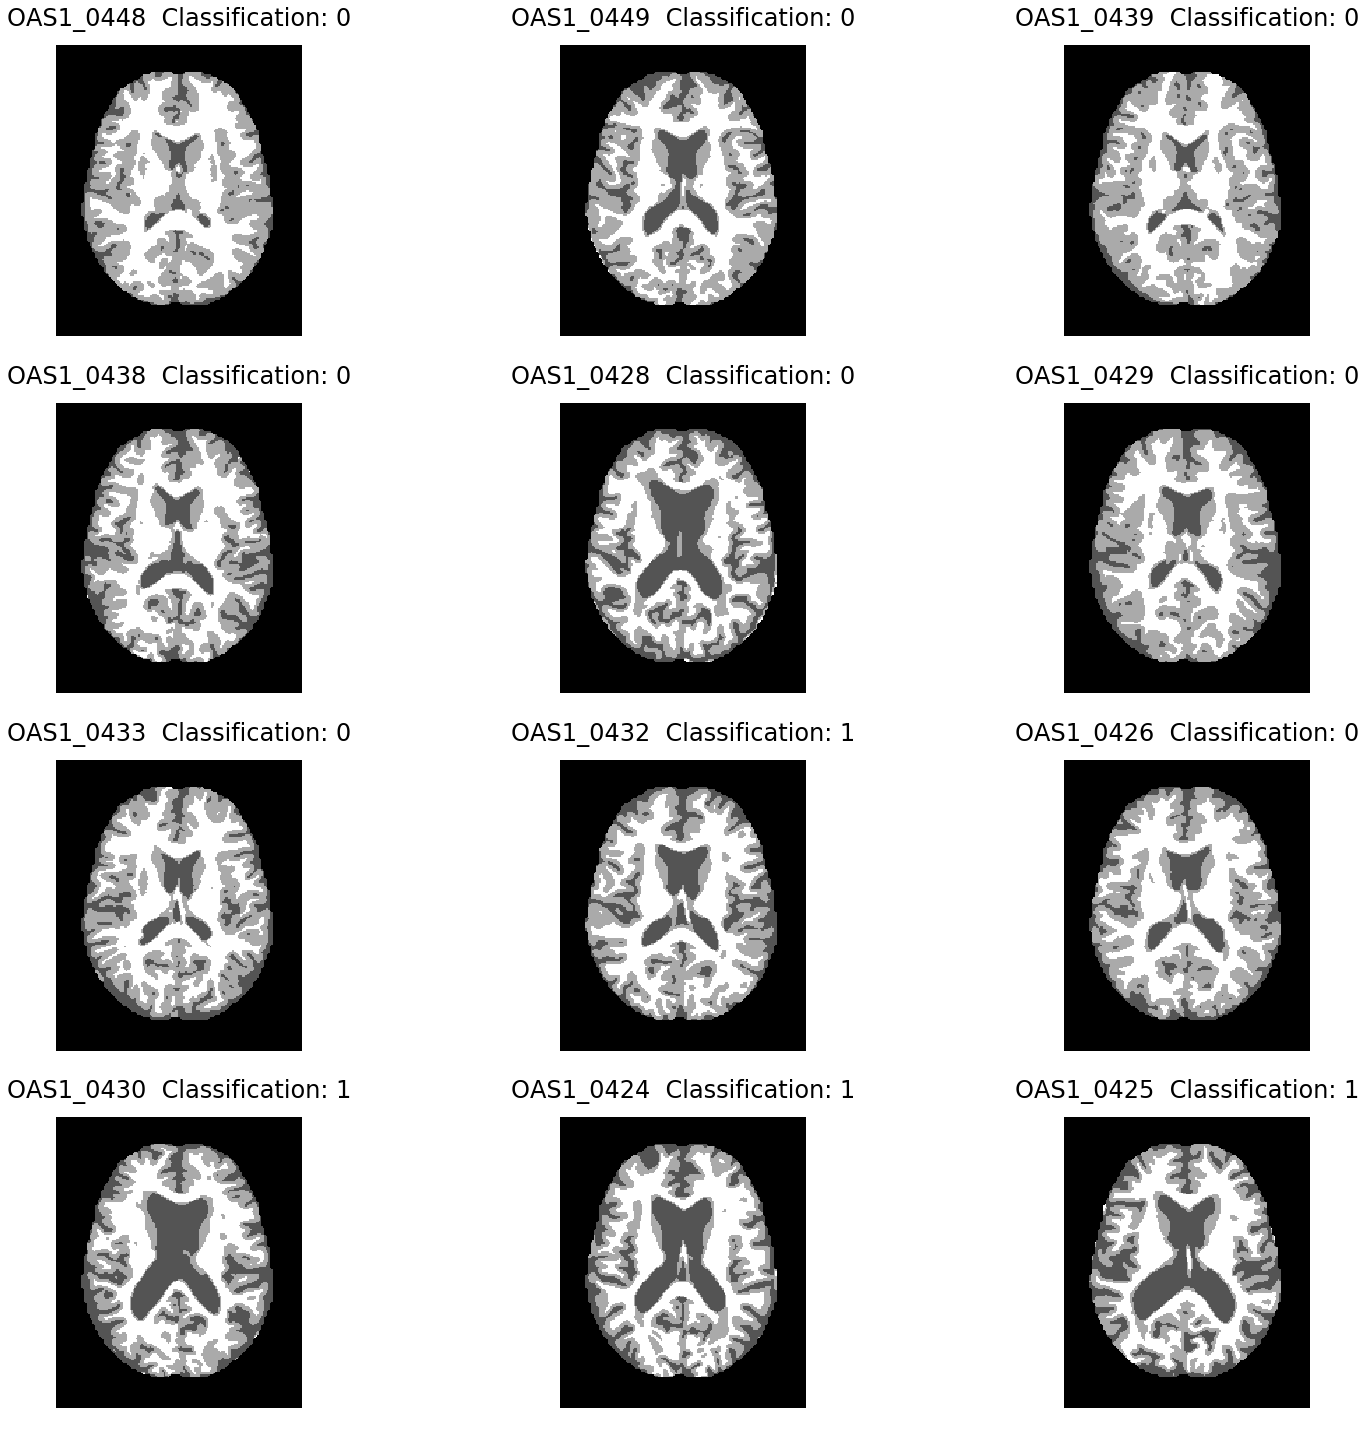

In [408]:
def plot_test_images(subject,diagnosis, array):
    plt.figure(figsize=(20, 20))
    print("Test Images".center(os.get_terminal_size().columns))
    for i in range(12):
        plt.subplot(4, 3, i+1)
        plt.title(str(subject[i]) +'  Classification: ' + str(diagnosis[i]), fontsize=24, pad = 20)
        plt.tight_layout()
        plt.axis('off')
        plt.imshow(array[i], cmap='gray')
        plt.subplots_adjust(wspace=0.25)
    plt.show()  
    
plot_test_images(subjects['Subject'],subjects['Diagnosis'],brain_array)

# T-SNE

In [ ]:
x = x[:,:,:,0]
tsne = TSNE(n_components=2, init='pca', random_state=42)
assert x.shape == (666, 208, 176)
X_tsne = tsne.fit_transform(x.reshape((666,208*176)))

In [ ]:
def run_tsne(X_tsne, y):
    X_t_train, X_t_test, y_t_train, y_t_test = train_test_split(X_tsne,y, random_state = 42)
    he = keras.initializers.he_normal(seed=42)   
    model_t = Sequential([
    Dense(50, input_shape=(2,), kernel_initializer=he),
    Activation('sigmoid'),
    Dense(20),
    Activation('sigmoid'),
    Dense(10),
    Activation('sigmoid'),
    Dense(1),
    Activation('sigmoid'),
    ])
    
    optimizer = keras.optimizers.Adam(lr=0.01, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
    model_t.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    
    return model_t, X_t_train, X_t_test, y_t_train, y_t_test, tsne

model_t, X_t_train, X_t_test, y_t_train, y_t_test, tsne= run_tsne(X_tsne,y)

# tboard = keras.callbacks.TensorBoard(log_dir='/Users/glynismattheisen/Desktop/Final',histogram_freq=5, write_graph=True, write_images=True)

In [327]:
model_t.fit(X_t_train,y_t_train,epochs=100, batch_size=50, validation_split=0.2)

Train on 399 samples, validate on 100 samples
Epoch 1/100
399/399 [==============================] - 1s 2ms/step - loss: 0.6479 - acc: 0.6692 - val_loss: 0.5555 - val_acc: 0.8600
Epoch 2/100
399/399 [==============================] - 0s 58us/step - loss: 0.5500 - acc: 0.8045 - val_loss: 0.4494 - val_acc: 0.8600
Epoch 3/100
399/399 [==============================] - 0s 46us/step - loss: 0.4928 - acc: 0.8045 - val_loss: 0.3968 - val_acc: 0.8500
Epoch 4/100
399/399 [==============================] - 0s 57us/step - loss: 0.4681 - acc: 0.8045 - val_loss: 0.3794 - val_acc: 0.8500
Epoch 5/100
399/399 [==============================] - 0s 78us/step - loss: 0.4536 - acc: 0.8070 - val_loss: 0.3728 - val_acc: 0.8600
Epoch 6/100
399/399 [==============================] - 0s 49us/step - loss: 0.4415 - acc: 0.8195 - val_loss: 0.3668 - val_acc: 0.8700
Epoch 7/100
399/399 [==============================] - 0s 89us/step - loss: 0.4346 - acc: 0.8170 - val_loss: 0.3652 - val_acc: 0.8700
Epoch 8/100
399/3

In [328]:
layer_dict = dict([(layer.name, layer) for layer in model_t.layers]) # get the symbolic outputs of each "key" layer (we gave them unique names).

In [329]:
tsne_accuracy, tsne_recall, tsne_precision = get_metrics(model_t,X_t_test, y_t_test)

167/167 [==============================] - 0s 48us/step


In [330]:
prediction = model_t.predict_classes(X_t_test)

# Visualize the T-SNE

In [391]:
X = x.reshape((666,208*176))
feat_cols = ['pixel'+str(i) for i in range(X.shape[1])] # name each column a pixel number
df = pd.DataFrame(X,columns=feat_cols) # convert X to dataframe
df['label'] = y
df['label'] = df['label'].apply(lambda i: str(i)) 
rndperm = np.random.permutation(df.shape[0])

plt.gray()
fig = plt.figure(figsize=(20,20))
for i in range(0,12):
    ax = fig.add_subplot(4,3,i+1, title='Classification: ' + str(df.loc[rndperm[i],'label']) )
    ax.matshow(df.loc[rndperm[i],feat_cols].values.reshape((208,176)).astype(float))
    plt.tight_layout()
plt.show()

AttributeError: 'int' object has no attribute 'reshape'

/Users/glynismattheisen/anaconda3/lib/python3.6/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning:

the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


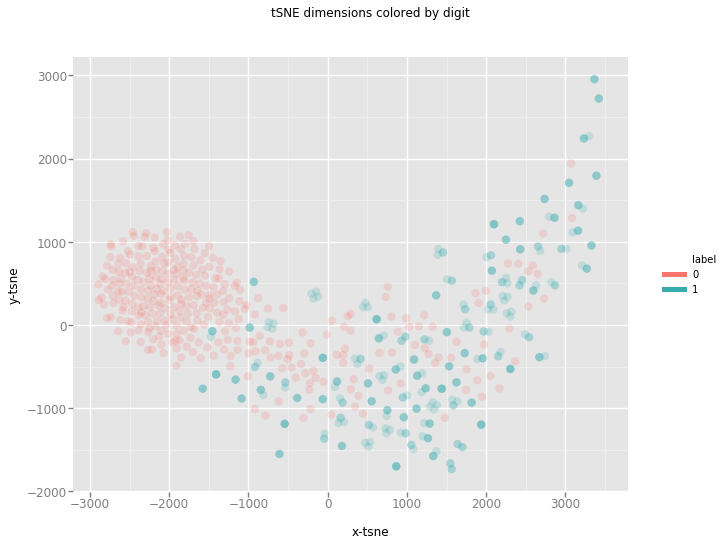

<ggplot: (7598895708)>

In [295]:
n_sne = 7000
tsne_results = tsne.fit_transform(df.loc[rndperm[:n_sne],feat_cols].values)

df_tsne = df.loc[rndperm[:n_sne],:].copy()
df_tsne['x-tsne'] = tsne_results[:,0]
df_tsne['y-tsne'] = tsne_results[:,1]

ggplot.ggplot(df_tsne, aes(x='x-tsne', y='y-tsne', color='label')) + geom_point(size=70,alpha=0.2) + ggtitle("tSNE dimensions colored by digit")

/Users/glynismattheisen/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning:

Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.



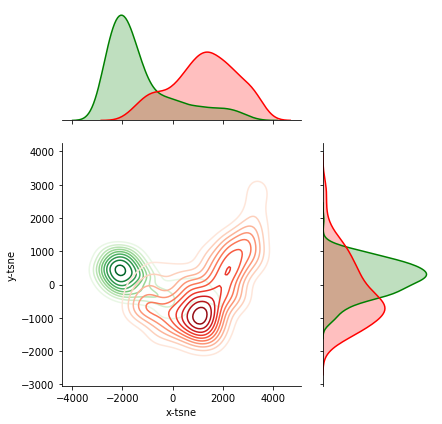

In [296]:
healthy = df_tsne.loc[df.label == "0"]
alz = df_tsne.loc[df.label == "1"]

g = sns.JointGrid(x="x-tsne", y="y-tsne", data=df_tsne, ratio = 2)
sns.kdeplot(healthy['x-tsne'], healthy['y-tsne'], cmap="Greens",
            shade=False, shade_lowest=False, ax=g.ax_joint)
sns.kdeplot(alz['x-tsne'], alz['y-tsne'], cmap="Reds",
            shade=False, shade_lowest=False, ax=g.ax_joint)
sns.kdeplot(healthy['x-tsne'], color="g", ax=g.ax_marg_x, shade = True, legend = False)
sns.kdeplot(alz['x-tsne'], color="r", ax=g.ax_marg_x, shade = True, legend = False)
sns.kdeplot(healthy['y-tsne'], color="g", ax=g.ax_marg_y, vertical=True, shade = True, legend = False)
sns.kdeplot(alz['y-tsne'], color="r", ax=g.ax_marg_y, vertical=True, shade = True, legend = False)
plt.show()

In [28]:
# --logdir=/Users/glynisttheisen/Desktop/Final

# PNCA

In [332]:
X.shape

(666, 36608)

In [333]:
m_PCA = PCA(n_components=10)
m_PCA.fit(X)
xt = m_PCA.transform(X)
xback = m_PCA.inverse_transform(xt)
assert X.shape == xback.shape
xback = xback.reshape((666,208,176))

In [305]:
def draw(subject, input):
    plt.figure(figsize=(20,20))

    for i in range(6):
        plt.subplot(3, 3, i+1)
        plt.title(str(subject[i]) + ' Classification: ' + str(df.loc[rndperm[i],'label']), fontsize=24, pad = 20)
        plt.imshow(input[i], cmap=plt.cm.Greys)
        plt.tight_layout()
        plt.subplots_adjust(wspace=0.25)
        plt.axis('off')
    plt.show()

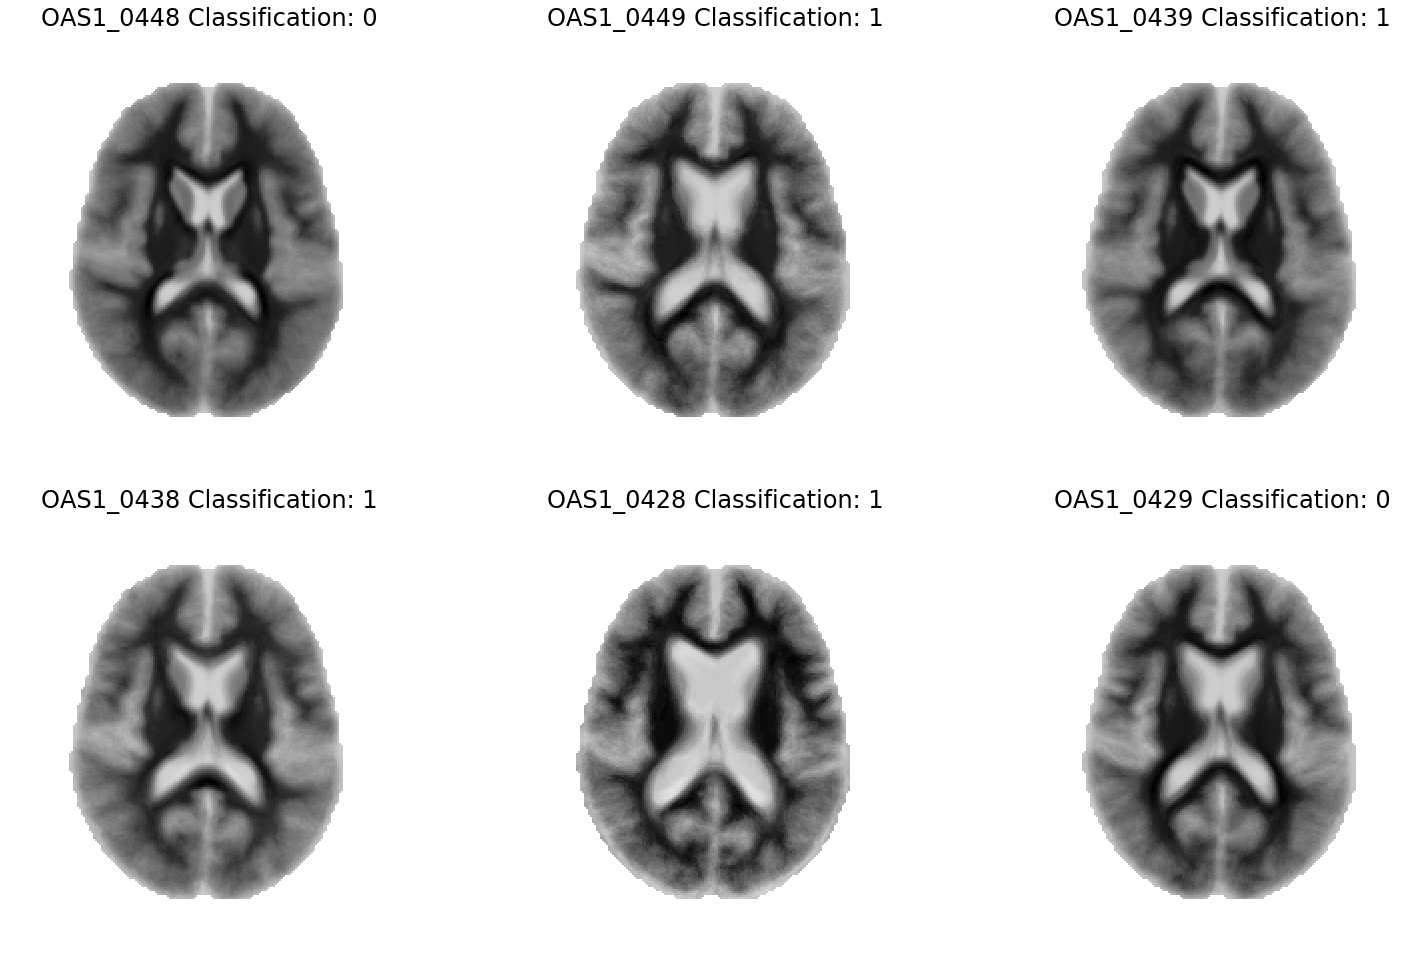

In [306]:
draw(subjects['Subject'], xback)

In [334]:
X_PCA_train, X_PCA_test, y_PCA_train, y_PCA_test = train_test_split(xt,y, random_state = 42)

he = keras.initializers.he_normal(seed=42)    

model_PCA = Sequential([
Dense(100, input_shape=(10,), kernel_initializer=he),
Activation('sigmoid'),
Dense(30),
Activation('sigmoid'),
Dense(15),
Activation('sigmoid'),
Dense(1),
Activation('sigmoid'),
])
optimizer = keras.optimizers.Adam(lr=0.01, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
model_PCA.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

In [335]:
model_PCA.fit(X_PCA_train,y_PCA_train,epochs=100, batch_size=50, validation_split=0.2)

Train on 399 samples, validate on 100 samples
Epoch 1/100
399/399 [==============================] - 1s 1ms/step - loss: 0.6159 - acc: 0.7469 - val_loss: 0.4563 - val_acc: 0.8600
Epoch 2/100
399/399 [==============================] - 0s 37us/step - loss: 0.4477 - acc: 0.8195 - val_loss: 0.3444 - val_acc: 0.8700
Epoch 3/100
399/399 [==============================] - 0s 34us/step - loss: 0.3844 - acc: 0.8446 - val_loss: 0.3095 - val_acc: 0.8700
Epoch 4/100
399/399 [==============================] - 0s 42us/step - loss: 0.3534 - acc: 0.8622 - val_loss: 0.2922 - val_acc: 0.8800
Epoch 5/100
399/399 [==============================] - 0s 54us/step - loss: 0.3322 - acc: 0.8822 - val_loss: 0.2878 - val_acc: 0.8900
Epoch 6/100
399/399 [==============================] - 0s 46us/step - loss: 0.3174 - acc: 0.8822 - val_loss: 0.2783 - val_acc: 0.8700
Epoch 7/100
399/399 [==============================] - 0s 51us/step - loss: 0.3114 - acc: 0.8797 - val_loss: 0.2684 - val_acc: 0.9000
Epoch 8/100
399/3

In [336]:
PCA_accuracy, PCA_recall, PCA_precision = get_metrics(model_PCA,X_PCA_test, y_PCA_test)

167/167 [==============================] - 0s 54us/step


# Feeding in data

In [36]:
sample = xt[1,].reshape(1,10) # take a sample from broad x set
sample.shape # shape of sample

(1, 10)

In [37]:
model_PCA.predict_classes(sample) # predict sample

array([[0]], dtype=int32)

# correct and incorrect predictions

In [337]:
wrong_predictions = []
correct_predictions = []
for i in range(167):
    if prediction[i][0] != y_t_test[i]:
        wrong_predictions.append(i)
    else:
        correct_predictions.append(i)

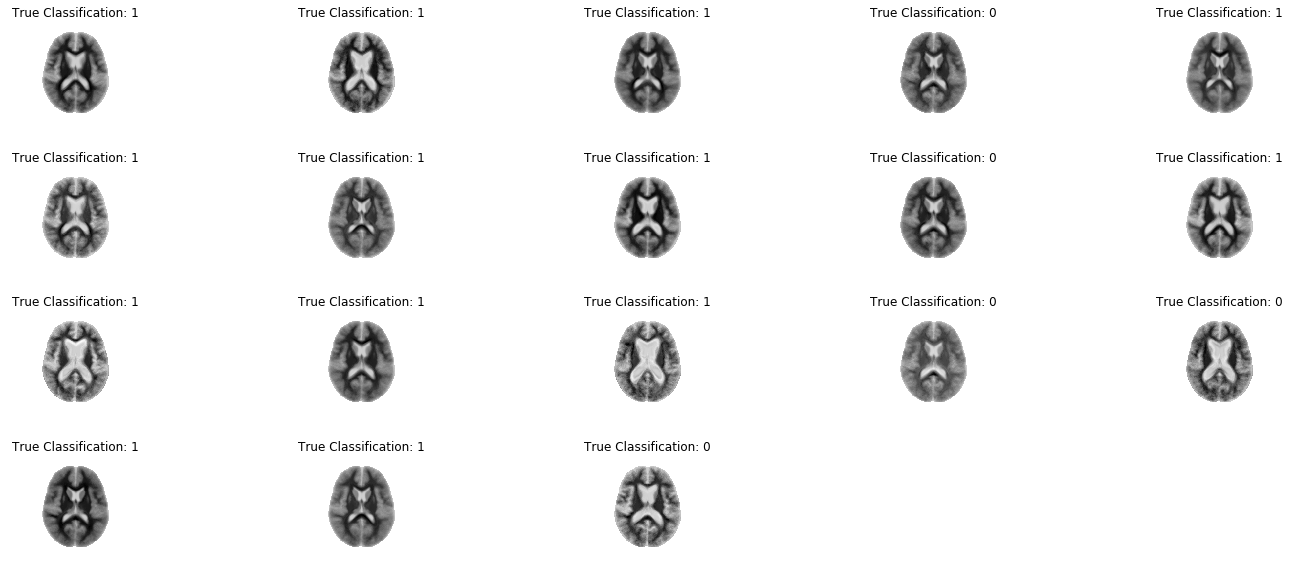

In [338]:
plt.figure(figsize=(20,20))

for x,i in enumerate(wrong_predictions):
    plt.subplot(10, 5, x+1)
    plt.title('True Classification: ' + str(df.loc[rndperm[i],'label']))
    plt.imshow(xback[i], cmap=plt.cm.Greys)
    plt.axis('off')
    plt.tight_layout()
plt.show()

In [339]:
len(correct_predictions)

149

In [340]:
correct_predictions = correct_predictions[:20]

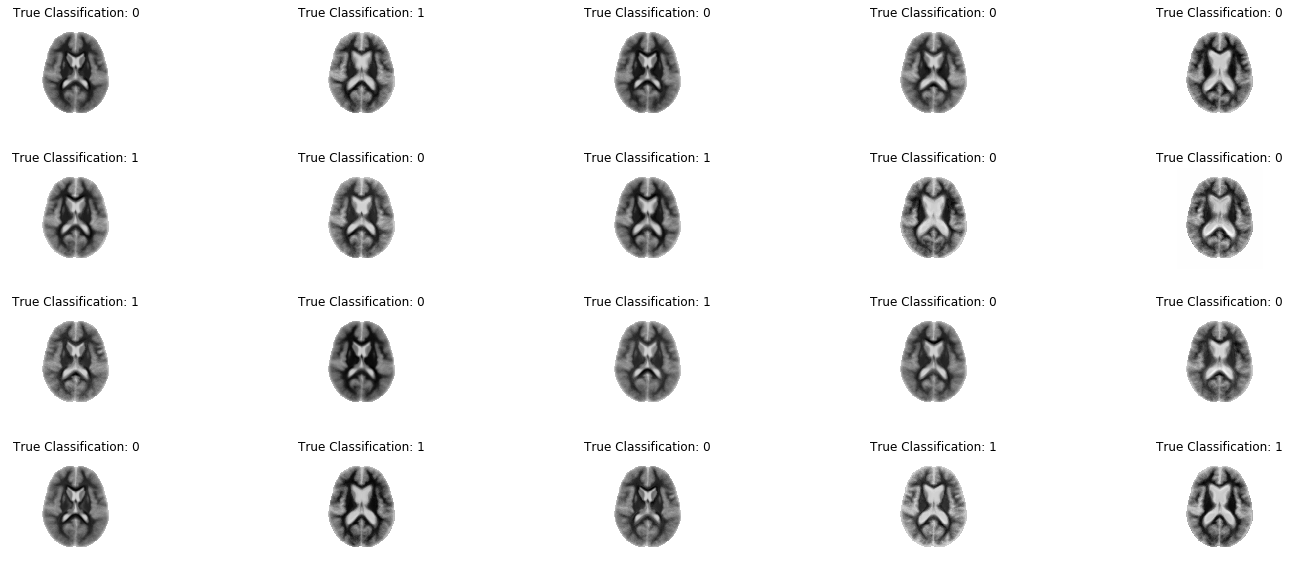

In [341]:
plt.figure(figsize=(20,20))

for x,i in enumerate(correct_predictions):
    plt.subplot(10, 5, x+1)
    plt.title('True Classification: ' + str(df.loc[rndperm[i],'label']))
    plt.imshow(xback[i], cmap=plt.cm.Greys)
    plt.axis('off')
    plt.tight_layout()
plt.show()

# Oasis 1 Textual Data

In [342]:
df = pd.read_csv('oasis1_cross-sectional.csv')
Subj_ID = []

for i in df['ID']:
    Subj_ID.append(get_subject(i))

df['Subject'] = pd.DataFrame(Subj_ID)

del df['ID']
del df['Hand']
del df['Delay']

In [343]:
df_demo = df[['Subject','M/F','Educ','SES','CDR','nWBV']].copy()

In [344]:
# Identify percentage of each categories composed of missing values
total = df_demo.isnull().sum().sort_values(ascending=False)
percent = df_demo.isnull().sum()/df_demo.isnull().count()*100
pd.concat([total, percent], axis=1, keys=['Total', '%'],sort=True)

,Total,%
CDR,199,46.279070
Educ,199,46.279070
M/F,0,0.000000
SES,218,50.697674
Subject,0,0.000000
nWBV,0,0.000000


In [345]:
df_demo['CDR'].fillna(0, inplace=True)
df_demo['CDR'].replace({0.5:1}, inplace=True) # replace 0.5 CDR values with 1 for Alz diagnosis
df_demo['CDR'].replace({2:1}, inplace=True) # replace 2 CDR values with 1 for Alz diagnosis

In [346]:
def replace_null(column): # fill null values with MEAN +/- STD
    mean = column.mean()
    std = column.std()
    is_null = column.isnull().sum()
    rand_VAR = np.random.randint(mean - std, mean + std, size = is_null)
    VAR_slice = column.copy()
    VAR_slice[np.isnan(VAR_slice)] = rand_VAR
    column = VAR_slice
    column = column.astype(int)
    return column

In [347]:
df_demo['Educ'] = replace_null(df_demo['Educ']) # fill missing Educ value with mean +/- SES
assert df_demo['Educ'].isnull().sum() == 0
df_demo['SES'] = replace_null(df_demo['SES']) # fill missing SES value with mean +/- SES
assert df_demo['SES'].isnull().sum() == 0

genders = {"M": 0, "F": 1}
df_demo['M/F'] = df_demo['M/F'].map(genders) # replace male = 0 and female = 1

In [348]:
temp_df = pd.DataFrame() 
for i in alz_subjects['Subject']:
    New_df = df_demo[df_demo['Subject'] == i]
    temp_df = temp_df.append(New_df, ignore_index=True) #Moving the contents of newly created dataframe to the temporary dataframe
    
total_df = df_demo.append(temp_df)
total_df.corr(method= 'pearson')

,M/F,Educ,SES,CDR,nWBV
M/F,1.000000,-0.072288,0.123503,-0.018493,0.014519
Educ,-0.072288,1.000000,-0.364870,0.081905,-0.162197
SES,0.123503,-0.364870,1.000000,0.312894,-0.370229
CDR,-0.018493,0.081905,0.312894,1.000000,-0.732078
nWBV,0.014519,-0.162197,-0.370229,-0.732078,1.000000


/Users/glynismattheisen/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning:

Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
/Users/glynismattheisen/anaconda3/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:488: RuntimeWarning:

invalid value encountered in true_divide

/Users/glynismattheisen/anaconda3/lib/python3.6/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning:

invalid value encountered in double_scalars

/Users/glynismattheisen/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:83: RuntimeWarning:

invalid value encountered in reduce

/Users/glynismattheisen/a

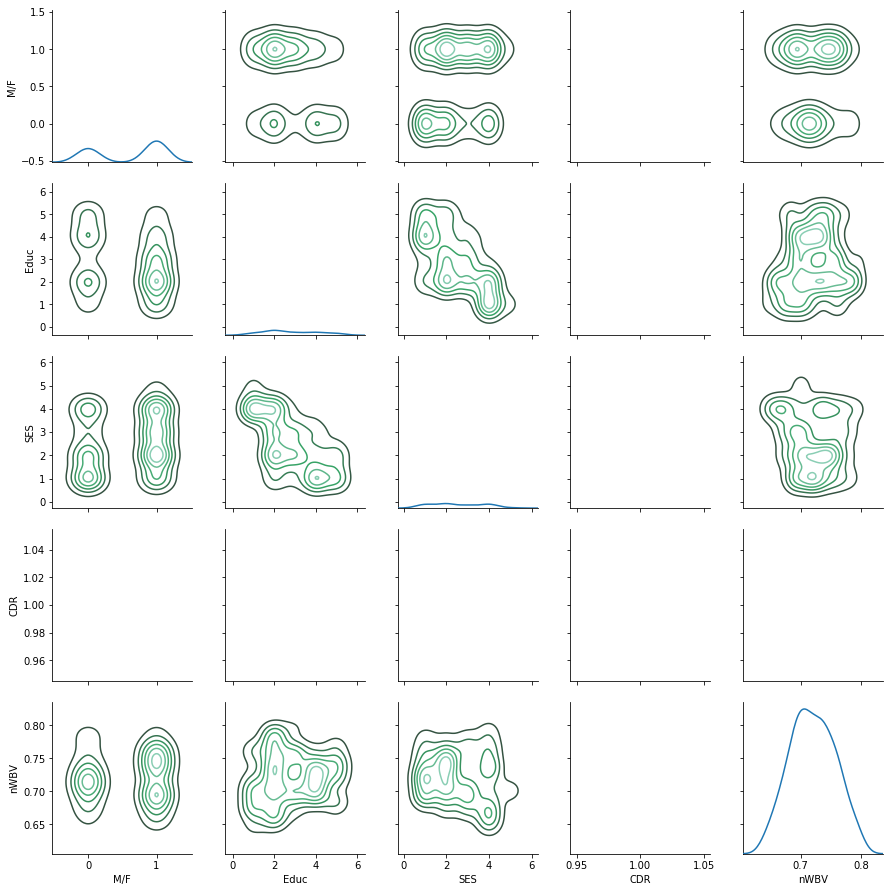

In [349]:
g = sns.PairGrid(temp_df)
g.map_diag(sns.kdeplot)
g.map_offdiag(sns.kdeplot, n_levels=6);

In [350]:
total_df = total_df.drop("M/F", axis=1)
total_df.set_index('Subject',inplace=True)

X_text = total_df.drop("CDR", axis=1)
y = total_df["CDR"]

assert X_text.shape == (666, 3)
assert y.shape == (666,)


In [351]:
X_text_train, X_text_test, y_text_train, y_text_test = train_test_split(X_text,y, random_state = 42)

model_txt = Sequential([
    Dense(150, input_shape=(3,)),
    Activation('relu'),
    Dropout(1.0),
    Dense(75),
    Activation('relu'),
    Dense(1),
    Activation('sigmoid'),
])

optimizer = keras.optimizers.Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
model_txt.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

In [352]:
model_txt.fit(X_text_train,y_text_train,epochs=100, batch_size=25)

Epoch 1/100
499/499 [==============================] - 1s 1ms/step - loss: 0.7139 - acc: 0.5010
Epoch 2/100
499/499 [==============================] - 0s 67us/step - loss: 0.6910 - acc: 0.5291
Epoch 3/100
499/499 [==============================] - 0s 77us/step - loss: 0.6801 - acc: 0.6954
Epoch 4/100
499/499 [==============================] - 0s 85us/step - loss: 0.6724 - acc: 0.6032
Epoch 5/100
499/499 [==============================] - 0s 83us/step - loss: 0.6669 - acc: 0.6473
Epoch 6/100
499/499 [==============================] - 0s 70us/step - loss: 0.6618 - acc: 0.6273
Epoch 7/100
499/499 [==============================] - 0s 61us/step - loss: 0.6566 - acc: 0.6914
Epoch 8/100
499/499 [==============================] - 0s 66us/step - loss: 0.6519 - acc: 0.6894
Epoch 9/100
499/499 [==============================] - 0s 64us/step - loss: 0.6475 - acc: 0.6393
Epoch 10/100
499/499 [==============================] - 0s 70us/step - loss: 0.6438 - acc: 0.6353
Epoch 11/100
499/499 [========

In [353]:
txt_accuracy, txt_recall, txt_precision = get_metrics(model_txt,X_text_test, y_text_test)

167/167 [==============================] - 0s 991us/step


# Random Forest

In [354]:
RanFor = RandomForestClassifier(max_depth = 2, n_estimators = 15)
RanFor.fit(X_text_train,y_text_train)
print ("Training score: " + str(round(RanFor.score(X_text_train,y_text_train)*100,2)) + '%')
print ("Test score: " + str(round(RanFor.score(X_text_test,y_text_test)*100,2)) + '%')

Training score: 87.17%
Test score: 88.62%


In [355]:
random_trees, random_depths =  random.sample(range(1,20),10), random.sample(range(1,50),25)

In [356]:
grid = GridSearchCV(RanFor, 
        param_grid={'n_estimators': random_trees, 'max_depth': random_depths},
        scoring='accuracy', 
        n_jobs=1,
        cv=5
        )

grid.fit(X_text_train,y_text_train)
print("Best score: " + str(round(grid.best_score_*100,2)) + '%', str(grid.best_params_))

Best score: 90.58% {'max_depth': 29, 'n_estimators': 8}


In [357]:
final_model = grid.best_estimator_
final_model.fit(X_text_train,y_text_train)

print ("Training score: " + str(final_model.score(X_text_train,y_text_train)))
print ("Test score: " + str(final_model.score(X_text_test,y_text_test)))

Training score: 0.9899799599198397
Test score: 0.9221556886227545


In [358]:
RF_txt_accuracy = round(final_model.score(X_text_test,y_text_test)*100,2)
txt_pred = final_model.predict(X_text_test)
RF_txt_recall = round((recall_score(y_text_test, txt_pred))*100, 2)
RF_txt_precision = round(precision_score(y_text_test, txt_pred)*100, 2)

# Oasis 1 FS

In [359]:
free = pd.read_csv('oasis1_FS.csv')
free.set_index('Subject', inplace=True)
subjects_x = subjects.set_index('Subject')

del free['FS_ASEGREGIONANALYSIS ID']
del free['MR ID']

subjects_x = subjects_x.head(423)
subjects_x = subjects_x.sort_index(ascending = True)

merge = free.merge(subjects_x, how='inner',left_index=True, right_index=True)

In [360]:
norm_to_ICV = lambda x : x / merge['ICV']

In [361]:
del merge['BrainMaskVol']
del merge['BrainSegNVox']
merge['BrainMaskNVox'] = norm_to_ICV(merge['BrainMaskNVox'])
merge['BrainSegVol'] = norm_to_ICV(merge['BrainSegVol'])

In [362]:
merge.corr()

,BrainMaskNVox,BrainSegVol,ICV,Diagnosis
BrainMaskNVox,1.000000,0.854474,-0.381174,-0.461668
BrainSegVol,0.854474,1.000000,-0.161257,-0.588211
ICV,-0.381174,-0.161257,1.000000,0.002552
Diagnosis,-0.461668,-0.588211,0.002552,1.000000


In [363]:
temp_df = pd.DataFrame() 
for i in alz_subjects['Subject']:
    New_df = df_demo[df_demo['Subject'] == i]
    temp_df = temp_df.append(New_df, ignore_index=True) #Moving the contents of newly created dataframe to the temporary dataframe
    
total_df = df_demo.append(temp_df)

total_df.set_index('Subject',inplace=True)

In [364]:
total_df = total_df.head(423)

In [365]:
merge_2 = merge.merge(total_df, how='inner',left_index=True, right_index=True)

In [366]:
merge_2.corr()

,BrainMaskNVox,BrainSegVol,ICV,Diagnosis,M/F,Educ,SES,CDR,nWBV
BrainMaskNVox,1.000000,0.858367,-0.391878,-0.447697,0.204238,-0.201340,-0.278583,-0.447697,0.620945
BrainSegVol,0.858367,1.000000,-0.172769,-0.581303,0.108956,-0.271766,-0.356924,-0.581303,0.861510
ICV,-0.391878,-0.172769,1.000000,-0.021834,-0.519074,-0.044887,-0.144234,-0.021834,0.040115
Diagnosis,-0.447697,-0.581303,-0.021834,1.000000,-0.032847,0.100210,0.308017,1.000000,-0.649548
M/F,0.204238,0.108956,-0.519074,-0.032847,1.000000,0.021849,0.031573,-0.032847,0.040699
Educ,-0.201340,-0.271766,-0.044887,0.100210,0.021849,1.000000,-0.156204,0.100210,-0.270763
SES,-0.278583,-0.356924,-0.144234,0.308017,0.031573,-0.156204,1.000000,0.308017,-0.406688
CDR,-0.447697,-0.581303,-0.021834,1.000000,-0.032847,0.100210,0.308017,1.000000,-0.649548
nWBV,0.620945,0.861510,0.040115,-0.649548,0.040699,-0.270763,-0.406688,-0.649548,1.000000


In [367]:
import plotly
import plotly.plotly as py
import plotly.graph_objs as go
plotly.offline.init_notebook_mode(connected=True)


/Users/glynismattheisen/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning:


The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.

/Users/glynismattheisen/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning:

Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.



Text(0.5, 1.0, 'Male')

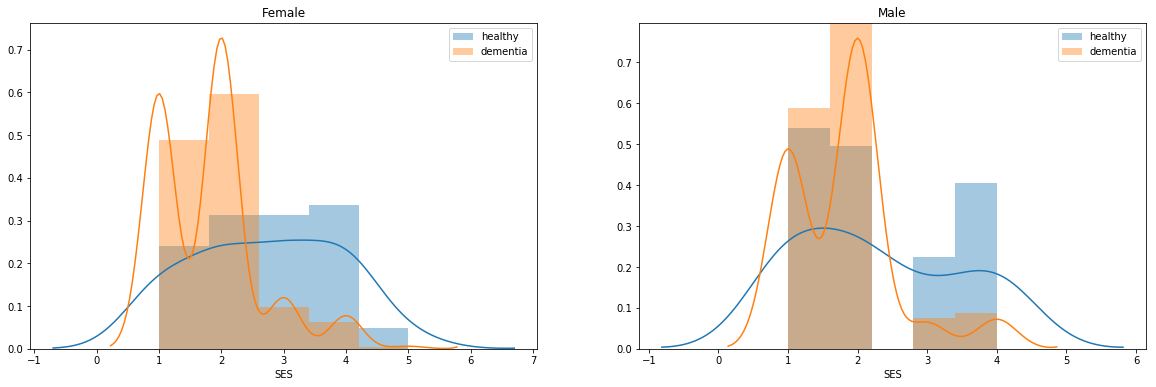

In [368]:
survived = 'healthy'
not_survived = 'dementia'
fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(20, 6))
women = merge_2[merge_2['M/F']== 1]
men = merge_2[merge_2['M/F']== 0]
ax = sns.distplot(women[women['CDR']==1.0].SES, bins=5, label = survived, ax = axes[0], kde =True)
ax = sns.distplot(women[women['CDR']==0.0].SES, bins=5, label = not_survived, ax = axes[0], kde =True)
ax.legend()
ax.set_title('Female')
ax = sns.distplot(men[men['CDR']==1].SES, bins=5, label = survived, ax = axes[1], kde = True)
ax = sns.distplot(men[men['CDR']==0].SES, bins=5, label = not_survived, ax = axes[1], kde = True)
ax.legend()
ax.set_title('Male')

/Users/glynismattheisen/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning:

Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.



Text(0.5, 1.0, 'Diagnosis and nWBV')

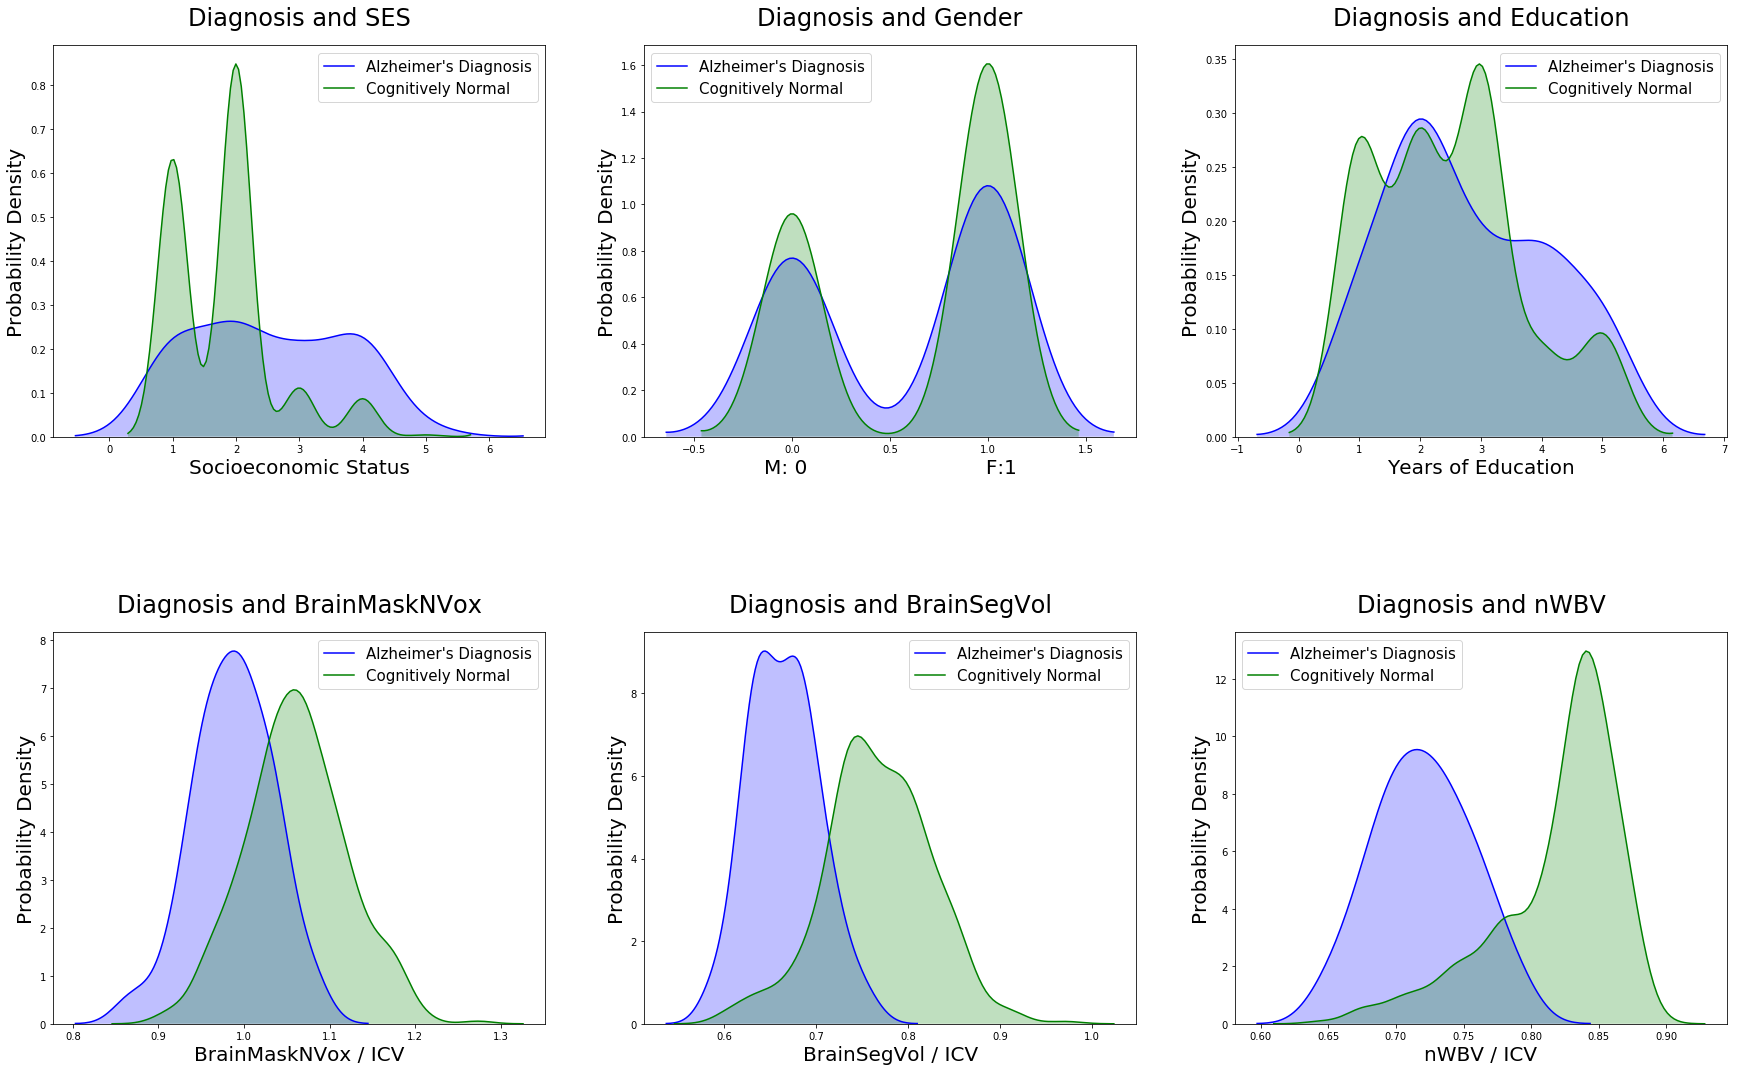

In [369]:
healthy = 'Cognitively Normal'
dementia = 'Alzheimer\'s Diagnosis'

fig = plt.figure(figsize=(30, 18))
grid = plt.GridSpec(2, 3, wspace=0.2, hspace=0.5)

plt.subplot(grid[0, 0])
ax = sns.kdeplot(merge_2[merge_2['Diagnosis']==1.0].SES, label = dementia, color='blue', shade=True)
ax = sns.kdeplot(merge_2[merge_2['Diagnosis']==0.0].SES, label = healthy, color ='green', shade=True)
ax.legend(fontsize=15)
plt.xlabel('Socioeconomic Status', fontsize=20)
plt.ylabel('Probability Density', fontsize=20)
ax.set_title('Diagnosis and SES', fontsize=24, pad = 20)

plt.subplot(grid[0, 1])
ax1 = sns.kdeplot(merge_2[merge_2['Diagnosis']==1.0]['M/F'], label = dementia, color='blue', shade=True)
ax1 = sns.kdeplot(merge_2[merge_2['Diagnosis']==0.0]['M/F'], label = healthy, color='green', shade=True)
ax1.legend(fontsize=15)
plt.xlabel('M: 0                            F:1', fontsize=20)
plt.ylabel('Probability Density', fontsize=20)
ax1.set_title('Diagnosis and Gender', fontsize=24, pad = 20)

plt.subplot(grid[0, 2])
ax2 = sns.kdeplot(merge_2[merge_2['Diagnosis']==1.0]['Educ'], label = dementia, color='blue', shade=True)
ax2 = sns.kdeplot(merge_2[merge_2['Diagnosis']==0.0]['Educ'], label = healthy, color='green', shade=True)
ax2.legend(fontsize=15)
plt.xlabel('Years of Education', fontsize=20)
plt.ylabel('Probability Density', fontsize=20)
ax2.set_title('Diagnosis and Education', fontsize=24, pad = 20)


plt.subplot(grid[1, 0])
ax = sns.kdeplot(merge_2[merge_2['Diagnosis']==1.0].BrainMaskNVox, label = dementia, shade=True, color='blue')
ax = sns.kdeplot(merge_2[merge_2['Diagnosis']==0.0].BrainMaskNVox, label = healthy, shade=True, color ='green')
plt.xlabel('BrainMaskNVox / ICV', fontsize=20)
plt.ylabel('Probability Density', fontsize=20)
ax.legend(fontsize=15)
ax.set_title('Diagnosis and BrainMaskNVox', fontsize=24, pad = 20)

plt.subplot(grid[1, 1])
ax1 = sns.kdeplot(merge_2[merge_2['Diagnosis']==1.0].BrainSegVol, label = dementia, shade=True,color='blue')
ax1 = sns.kdeplot(merge_2[merge_2['Diagnosis']==0.0].BrainSegVol, label = healthy, shade=True,color='green')
plt.xlabel('BrainSegVol / ICV', fontsize=20)
plt.ylabel('Probability Density', fontsize=20)
ax1.legend(fontsize=15)
ax1.set_title('Diagnosis and BrainSegVol', fontsize=24, pad = 20)

plt.subplot(grid[1, 2])
ax1 = sns.kdeplot(merge_2[merge_2['Diagnosis']==1.0].nWBV, label = dementia, shade=True,color='blue')
ax1 = sns.kdeplot(merge_2[merge_2['Diagnosis']==0.0].nWBV, label = healthy, shade=True,color='green')
plt.xlabel('nWBV / ICV', fontsize=20)
plt.ylabel('Probability Density', fontsize=20)
ax1.legend(fontsize=15)
ax1.set_title('Diagnosis and nWBV', fontsize=24, pad = 20)

In [370]:
merge_2.head(4)

,BrainMaskNVox,BrainSegVol,ICV,Diagnosis,M/F,Educ,SES,CDR,nWBV
Subject,,,,,,,,,
OAS1_0002,1.069785,0.762842,1151269.287,0,1,4,1,0.0,0.810
OAS1_0003,0.994005,0.677106,1403415.054,1,1,4,3,1.0,0.708
OAS1_0004,1.008911,0.729594,1593284.910,0,0,1,2,0.0,0.803
OAS1_0005,1.036834,0.789169,1733779.281,0,0,2,1,0.0,0.848


In [371]:
del merge_2['CDR']
del merge_2['ICV']

In [372]:
corr = merge_2.corr()

In [373]:
corr

,BrainMaskNVox,BrainSegVol,Diagnosis,M/F,Educ,SES,nWBV
BrainMaskNVox,1.000000,0.858367,-0.447697,0.204238,-0.201340,-0.278583,0.620945
BrainSegVol,0.858367,1.000000,-0.581303,0.108956,-0.271766,-0.356924,0.861510
Diagnosis,-0.447697,-0.581303,1.000000,-0.032847,0.100210,0.308017,-0.649548
M/F,0.204238,0.108956,-0.032847,1.000000,0.021849,0.031573,0.040699
Educ,-0.201340,-0.271766,0.100210,0.021849,1.000000,-0.156204,-0.270763
SES,-0.278583,-0.356924,0.308017,0.031573,-0.156204,1.000000,-0.406688
nWBV,0.620945,0.861510,-0.649548,0.040699,-0.270763,-0.406688,1.000000


In [374]:
healthy = merge_2[merge_2['Diagnosis'] ==0]
alz = merge_2[merge_2['Diagnosis'] ==1]
healthy.describe()

,BrainMaskNVox,BrainSegVol,Diagnosis,M/F,Educ,SES,nWBV
count,409.000000,409.000000,409.0,409.000000,409.000000,409.000000,409.000000
mean,1.061428,0.767137,0.0,0.625917,2.476773,1.799511,0.819218
std,0.058718,0.057977,0.0,0.484478,1.206629,0.794528,0.046090
min,0.898880,0.598557,0.0,0.000000,1.000000,1.000000,0.645000
25%,1.024003,0.731835,0.0,0.000000,1.000000,1.000000,0.800000
50%,1.061511,0.768665,0.0,1.000000,2.000000,2.000000,0.834000
75%,1.098918,0.806031,0.0,1.000000,3.000000,2.000000,0.850000
max,1.273024,0.971192,0.0,1.000000,5.000000,5.000000,0.893000


In [375]:
alz.describe()

,BrainMaskNVox,BrainSegVol,Diagnosis,M/F,Educ,SES,nWBV
count,89.000000,89.000000,89.0,89.00000,89.000000,89.000000,89.000000
mean,0.987466,0.665045,1.0,0.58427,2.797753,2.539326,0.720247
std,0.046273,0.037125,0.0,0.49564,1.298424,1.187589,0.036040
min,0.862992,0.585271,1.0,0.00000,1.000000,1.000000,0.644000
25%,0.954419,0.637336,1.0,0.00000,2.000000,2.000000,0.694000
50%,0.989696,0.664340,1.0,1.00000,2.000000,2.000000,0.719000
75%,1.023574,0.688246,1.0,1.00000,4.000000,4.000000,0.745000
max,1.084934,0.761927,1.0,1.00000,5.000000,5.000000,0.797000


In [376]:
columns = corr.columns.values

In [377]:
z = [-0.447697,-0.581303,1, -0.032847,0.079117,0.340303,-0.649548]

list_n = [item*150 for item in z] 

abs_list = lambda x :abs(x) # normalize x values

for x, i in enumerate(list_n):
    list_n[x] = abs(i)

In [378]:
import plotly.plotly as py
import plotly.graph_objs as go

z = [-0.447697,-0.581303,1, -0.032847,0.079117,0.340303,-0.649548]

trace0 = go.Scatter(
    x=[-3.5,-2.5, 0, -4.5, 2.25, 1.25, -1.5],
    y=[-0.447697,-0.581303,1, -0.032847,0.079117,0.340303,-0.649548],
    text=columns,
    hoverinfo = 'y',
    textposition=['bottom center','top center','middle center','bottom center','bottom center','middle center','middle center'],
    mode='markers + text',
    marker=dict(
        color =[300,325,375,275,325,350,350],
        opacity=[0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5],
        size=list_n,
        showscale=False

    )
)

layout = go.Layout(
    xaxis=dict(
        autorange=True,
        showgrid=False,
        zeroline=False,
        showline=False,
        ticks='',
        showticklabels=False
    ),
    yaxis=dict(
        range=[-25,25],
        showgrid=False,
        zeroline=False,
        showline=False,
        ticks='',
        showticklabels=False
    )
)

data = [trace0]
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='bubblechart-color')



In [379]:
merge_2.head()

,BrainMaskNVox,BrainSegVol,Diagnosis,M/F,Educ,SES,nWBV
Subject,,,,,,,
OAS1_0002,1.069785,0.762842,0,1,4,1,0.810
OAS1_0003,0.994005,0.677106,1,1,4,3,0.708
OAS1_0004,1.008911,0.729594,0,0,1,2,0.803
OAS1_0005,1.036834,0.789169,0,0,2,1,0.848
OAS1_0007,1.027285,0.754648,0,0,3,1,0.830


In [380]:
X_text = merge_2.drop("Diagnosis", axis=1)
y = merge_2["Diagnosis"]
X_text_train, X_text_test, y_text_train, y_text_test = train_test_split(X_text,y, random_state = 42)

In [381]:
RanFor = RandomForestClassifier(max_depth = 2, n_estimators = 15)
RanFor.fit(X_text_train,y_text_train)
print ("Training score: " + str(round(RanFor.score(X_text_train,y_text_train)*100,2)) + '%')
print ("Test score: " + str(round(RanFor.score(X_text_test,y_text_test)*100,2)) + '%')

Training score: 90.62%
Test score: 85.6%


In [382]:
random_trees, random_depths =  random.sample(range(1,30),10), random.sample(range(1,50),25)

In [383]:
random_depth =  random.sample(range(1,30),10)

In [384]:
grid = GridSearchCV(RanFor, 
        param_grid={'max_depth': random_trees, 'n_estimators': random_depths},
        scoring='accuracy', 
        n_jobs=1,
        cv=5
        )

grid.fit(X_text_train,y_text_train)
print("Best score: " + str(round(grid.best_score_*100,2)) + '%', str(grid.best_params_))

Best score: 90.35% {'max_depth': 3, 'n_estimators': 35}


In [385]:
X_text_train.head(2)

,BrainMaskNVox,BrainSegVol,M/F,Educ,SES,nWBV
Subject,,,,,,
OAS1_0056,1.007822,0.642981,1,3,3,0.668
OAS1_0038,1.059964,0.767112,1,3,2,0.839


In [386]:
final_model = grid.best_estimator_
final_model.fit(X_text_train,y_text_train)

print ("Training score: " + str(final_model.score(X_text_train,y_text_train)))
print ("Test score: " + str(final_model.score(X_text_test,y_text_test)))

Training score: 0.9195710455764075
Test score: 0.872


In [387]:
RF_txt_vol_accuracy = round(final_model.score(X_text_test,y_text_test)*100,2)
txt_vol_pred = final_model.predict(X_text_test)
RF_txt_vol_recall = round((recall_score(y_text_test, txt_vol_pred))*100, 2)
RF_txt_vol_precision = round(precision_score(y_text_test, txt_vol_pred)*100, 2)

In [388]:
estimator = final_model.estimators_[5]

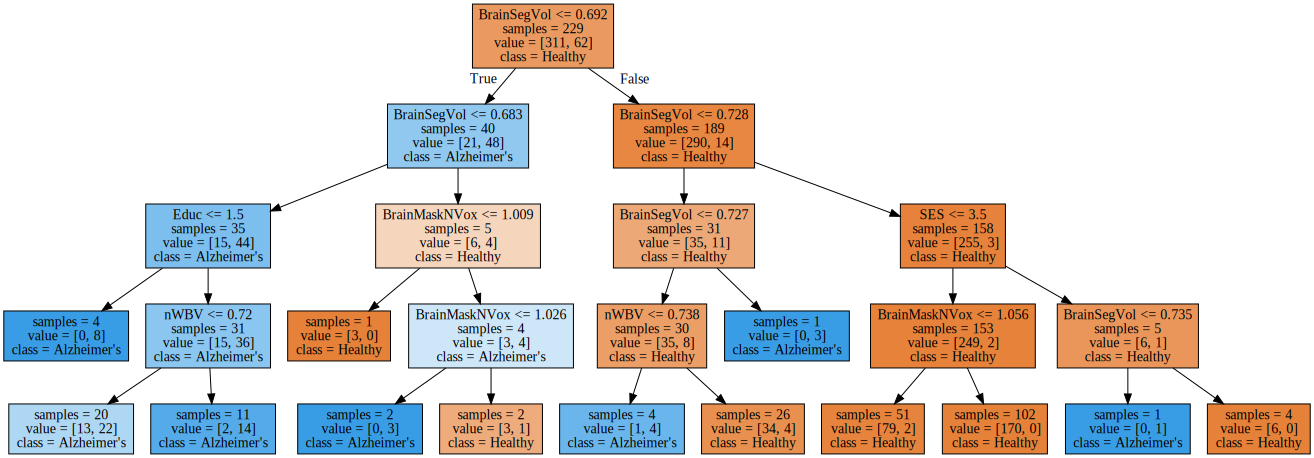

In [311]:
tree = export_graphviz(estimator, out_file=None, 
                class_names=["Healthy", "Alzheimer's"], 
                feature_names=['BrainMaskNVox','BrainSegVol','M/F','Educ','SES','nWBV'],
                impurity=False,
                filled=True)

graph = graphviz.Source(tree)
graph.render('DecTree')  # creates PDF
graph  # in Jupyter

## Results

In [389]:
result_df = pd.DataFrame({
    'Model': ['NN','T-SNE + NN','PCA + NN','Demographic Data + RF'],
    'Accuracy': [model_accuracy,tsne_accuracy,PCA_accuracy, RF_txt_vol_accuracy],
    'Precision': [model_precision,tsne_precision,PCA_precision, RF_txt_vol_precision],
    'Recall': [model_recall,tsne_recall,PCA_recall, RF_txt_vol_recall]
 })
result_df = results.sort_values(by='Accuracy', ascending=False)
result_df = result_df.set_index('Model')
result_df

,Accuracy,Precision,Recall
Model,,,
PCA + NN,94.61,92.13,97.62
T-SNE + NN,88.02,87.21,89.29
NN,86.83,82.29,94.05
Demographic Data + RF,84.80,62.96,65.38


In [390]:
result_df.style.background_gradient(cmap='GnBu', low=1, high=0.75, axis=0).set_properties(**{'font-size':'15pt'})

,Accuracy,Precision,Recall
Model,,,
PCA + NN,94.61,92.13,97.62
T-SNE + NN,88.02,87.21,89.29
NN,86.83,82.29,94.05
Demographic Data + RF,84.8,62.96,65.38
